# MBS Duration Exposure

# Packages

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats

# Read in Data

In [2]:
df_mtge = (pd.read_parquet(
    path = "mtge.parquet",
    engine = "pyarrow").
    dropna().
    drop(columns = ["field"]))

df_mbs = (pd.read_parquet(
    path = "mbs.parquet",
    engine = "pyarrow").
    dropna().
    drop(columns = ["field"]))

df_duration = (pd.read_parquet(
    path = "mbs_duration.parquet",
    engine = "pyarrow").
    drop(columns = ["field"]))

df = pd.concat([df_mtge, df_mbs, df_duration])

# Background Research

First examine house supply

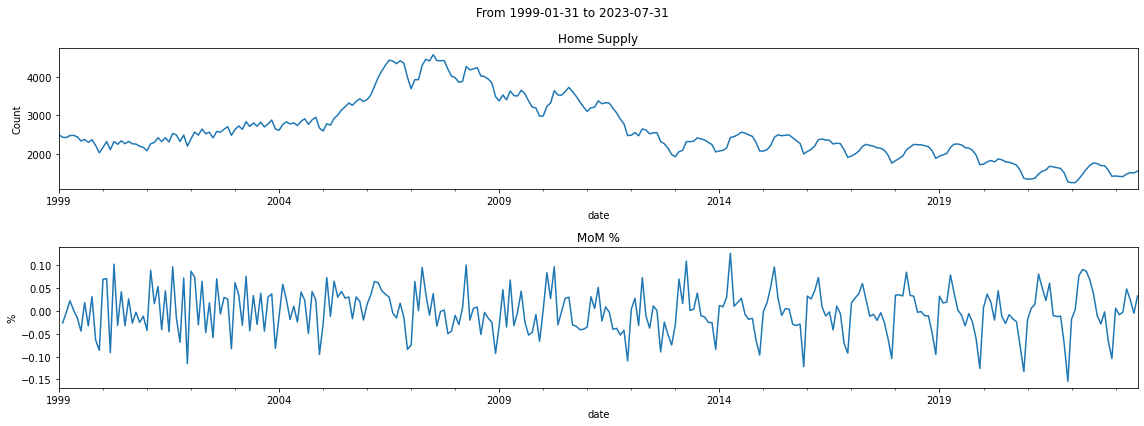

In [3]:
df_home_supply = (df.query(
    "ticker == ['.HOMESUP G Index']").
    pivot(index = "date", columns = "ticker", values = "value").
    rename(columns = {".HOMESUP G Index": "Home Supply"}).
    assign(change = lambda x: x["Home Supply"].pct_change()).
    rename(columns = {"change": "MoM %"}))

fig, axes = plt.subplots(nrows = 2, figsize = (16, 6))

for i, col in enumerate(df_home_supply.columns):

     (df_home_supply[
        col].
        plot(
            ax = axes[i],
            title = col,
            legend = False))

fig.suptitle("From {} to {}".format(
    df_home_supply.index.min().date(),
    df_home_supply.index.max().date()))

axes[0].set_ylabel("Count")
axes[1].set_ylabel("%")

plt.tight_layout()
plt.show()

Look at convexity, the proxy for this is by looking at duration. As rates increase convexity increases as people don't prepay. This extends the maturity (duration) of the MBS thus duration is a relatively good proxy for duration.

In [4]:
df_duration = (df.query(
    "ticker == 'LUMSMD Index'").
    pivot(index = "date", columns = "ticker", values = "value").
    rename(columns = {"LUMSMD Index": "LUMSMD"}).
    assign(z_score = lambda x: (x.LUMSMD - x.LUMSMD.rolling(window = 90).mean()) / x.LUMSMD.rolling(window = 90).std()).
    dropna().
    rename(columns = {"z_score": "90d Rolling Z-Score"}).
    reset_index().
    query("date > '1992-01-01'").
    set_index("date"))

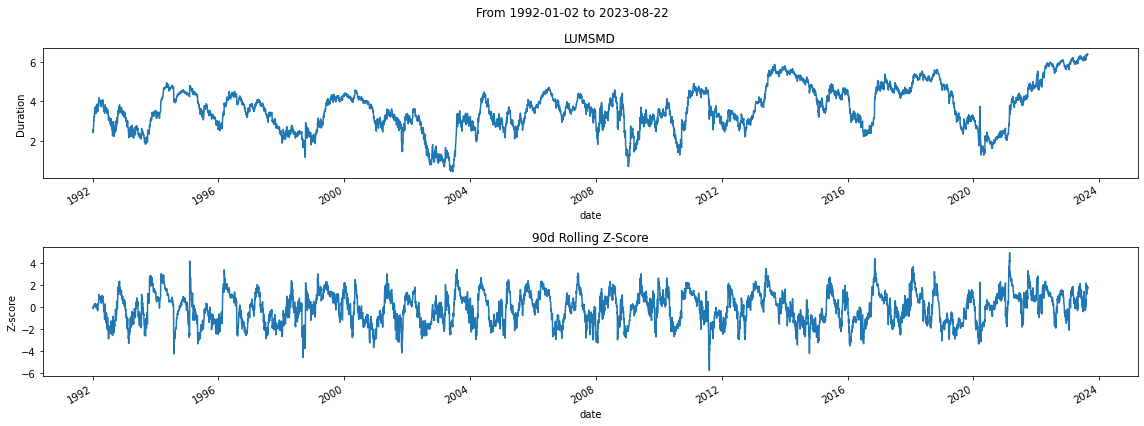

In [5]:
fig, axes = plt.subplots(nrows = 2, figsize = (16, 6))

for i, col in enumerate(df_duration.columns):
    (df_duration[
        col].
        plot(
            ax  = axes[i],
            title = col))

axes[0].set_ylabel("Duration")
axes[1].set_ylabel("Z-score")

fig.suptitle("From {} to {}".format(
    df_duration.index.min().date(),
    df_duration.index.max().date()))

plt.tight_layout()

Intresting enough the rolling z-score is not to high or low

In [6]:
df_duration_pct = (df_duration.assign(
    roll_change = lambda x: x.LUMSMD.pct_change(periods = 30)).
    rename(columns = {"roll_change": "LUMSMD Monthly Change"}))

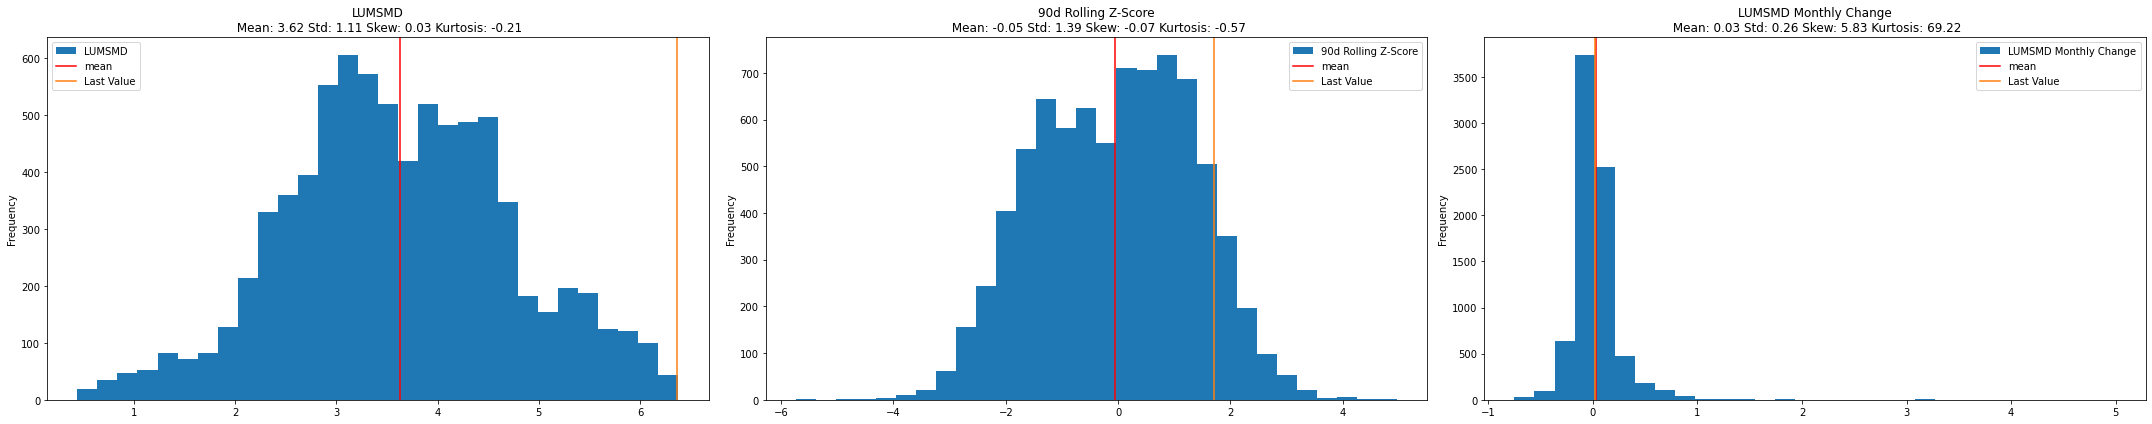

In [31]:
cols = df_duration_pct.columns.to_list()
fig, axes = plt.subplots(ncols = len(cols), figsize = (30, 6))

j = 0
for i, col in enumerate(cols):
    
    df_tmp = df_duration_pct[col].dropna()
    mean, std, skew, kurtosis = df_tmp.mean(), df_tmp.std(), df_tmp.skew(), df_tmp.kurtosis()
    last = df_tmp.reset_index().query("date == date.max()")[col].iloc[0]
    
    (df_tmp.plot(
        ax = axes[i],
        kind = "hist",
        bins = 30,
        title = "{}\n Mean: {} Std: {} Skew: {} Kurtosis: {}".format(
            col,
            round(mean, 2),
            round(std, 2),
            round(skew, 2),
            round(kurtosis, 2))))
    
    axes[i].axvline(mean, color = "r", label = "mean")
    axes[i].axvline(last, color = "tab:orange", label = "Last Value")
    axes[i].legend()
    
plt.tight_layout()

# MBS Rates model

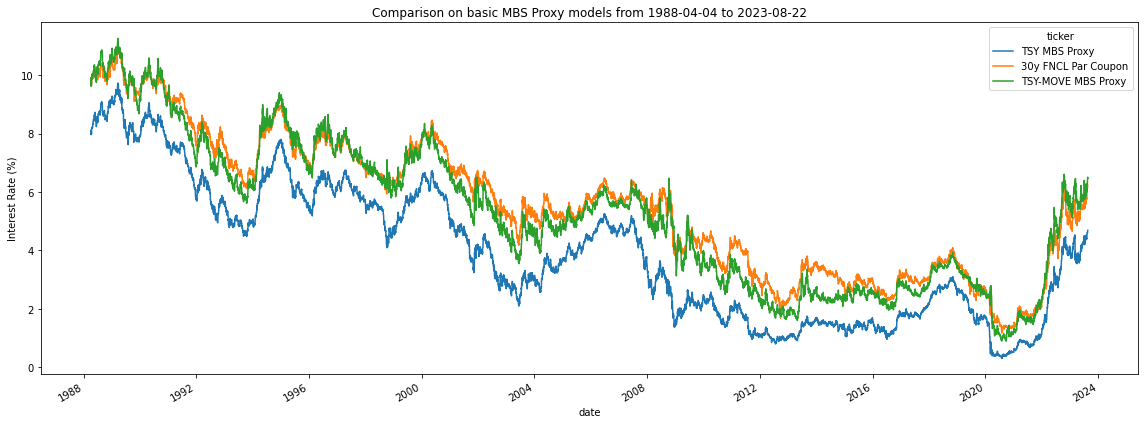

In [8]:
df_mbs_model = (df.query(
    "ticker == ['USGG10YR Index', 'USGG2YR Index', 'MOVE Index', 'MTGEFNCL Index']").
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna().
    assign(
        mbs_proxy = lambda x: (x.USGG10YR + x.USGG2YR) / 2,
        mbs_vol_proxy = lambda x: x.mbs_proxy + (0.014049 * x.MOVE))
    [["mbs_proxy", "MTGEFNCL", "mbs_vol_proxy"]].
    rename(columns = {
        "mbs_proxy": "TSY MBS Proxy",
        "mbs_vol_proxy": "TSY-MOVE MBS Proxy",
        "MTGEFNCL": "30y FNCL Par Coupon"}))

(df_mbs_model.plot(
  ylabel = "Interest Rate (%)",
  figsize = (16,6),
  title = "Comparison on basic MBS Proxy models from {} to {}".format(
      df_mbs_model.index.min().date(),
      df_mbs_model.index.max().date())))

plt.tight_layout()
plt.show()

Running Regression on Mortgage rate models vs. 30y Mortgage Rate

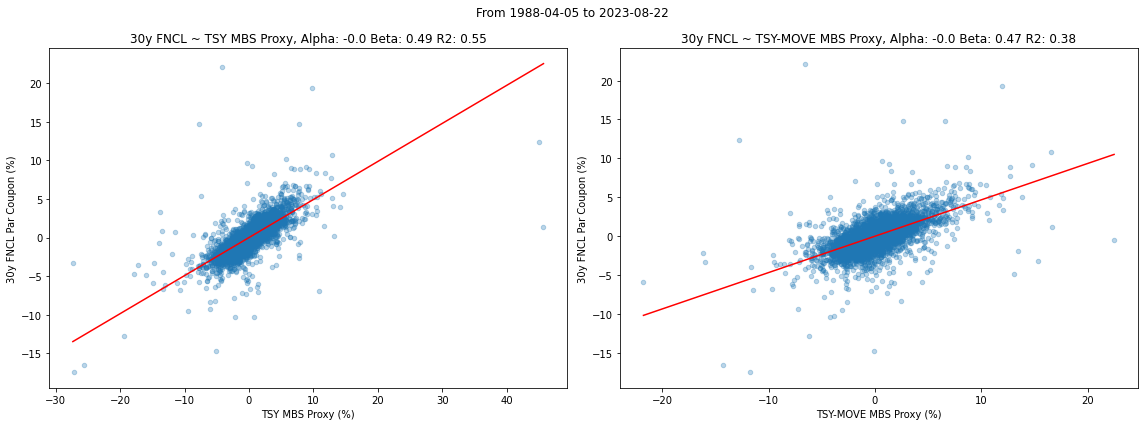

In [32]:
exog_variables = ["TSY MBS Proxy", "TSY-MOVE MBS Proxy"]
df_params = pd.DataFrame(columns = ["exog", "alpha", "beta", "rsquared"])
df_resid = pd.DataFrame()

fig, axes = plt.subplots(ncols = len(exog_variables), figsize = (16, 6))

for i, col in enumerate(exog_variables):

    df_tmp = df_mbs_model[[col, "30y FNCL Par Coupon"]].pct_change().dropna() * 100
    
    (df_tmp[
        [col, "30y FNCL Par Coupon"]].
        plot(
            kind = "scatter",
            x = col,
            y = "30y FNCL Par Coupon",
            xlabel = "{} (%)".format(col),
            ylabel = "30y FNCL Par Coupon (%)",
            ax = axes[i],
            alpha = 0.3))

    lm_model = (sm.OLS(
        endog = df_tmp["30y FNCL Par Coupon"],
        exog = sm.add_constant(df_tmp[col])).
        fit())

    alpha, beta = lm_model.params
    rsquared = lm_model.rsquared

    x = np.linspace(
        start = df_tmp[col].min(),
        stop = df_tmp[col].max(),
        num = 1_000)

    y = (beta * x) + alpha

    axes[i].plot(x, y, color = "r")
    axes[i].set_title("30y FNCL ~ {}, Alpha: {} Beta: {} R2: {}".format(
        col,
        round(alpha, 2),
        round(beta, 2),
        round(rsquared, 2)))
    
    df_params = df_params.append([
        pd.DataFrame({
            "exog": [col],
            "alpha": [alpha],
            "beta": [beta],
            "rsquared": [rsquared]})])
    
    df_resid = df_resid.append(
        lm_model.resid.to_frame().assign(exog = col).
        rename(columns = {0: "residual"}))

fig.suptitle("From {} to {}".format(
    df_tmp.index.min().date(),
    df_tmp.index.max().date()))

plt.tight_layout()
plt.show()

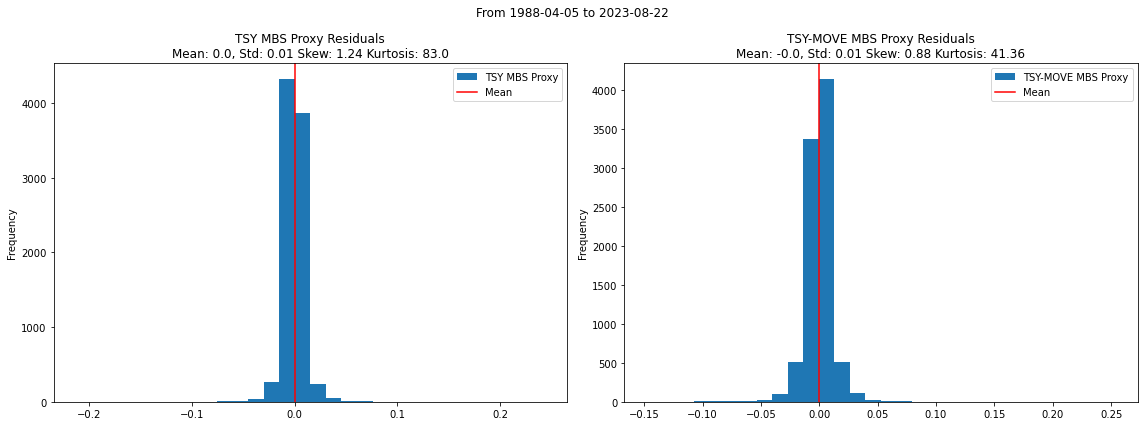

In [10]:
df_resid_longer = (df_resid.reset_index().pivot(
    index = "date", columns = "exog", values = "residual"))
cols = df_resid_longer.columns.to_list()

fig, axes = plt.subplots(ncols = 2, figsize = (16,6))
for i, col in enumerate(cols):
    
    df_tmp = (df_resid_longer[col])
    mean, std, skew, kurtosis = df_tmp.mean(), df_tmp.std(), df_tmp.skew(), df_tmp.kurtosis()

    (df_tmp.plot(
        kind = "hist",
        ax = axes[i],
        bins = 30,
        title = "{} Residuals\nMean: {}, Std: {} Skew: {} Kurtosis: {}".format(
            col,
            round(mean, 2),
            round(std, 2),
            round(skew, 2),
            round(kurtosis, 2))))

    axes[i].axvline(
        mean,
        color = "red",
        label = "Mean")

    axes[i].legend()


fig.suptitle("From {} to {}".format(
    df_tmp.index.min().date(),
    df_tmp.index.max().date()))

plt.tight_layout()
plt.show()

In [11]:
def _moments(df: pd.DataFrame) -> pd.DataFrame:
    return(pd.DataFrame({
        "mean": [df.value.mean()],
        "Standard Deviation": [df.value.std()],
        "skew": [df.value.skew()],
        "kurtosis": [df.value.kurtosis()]}))

df_resid_moment = (df_resid_longer.reset_index().melt(
    id_vars = "date").
    groupby("exog").
    apply(_moments))

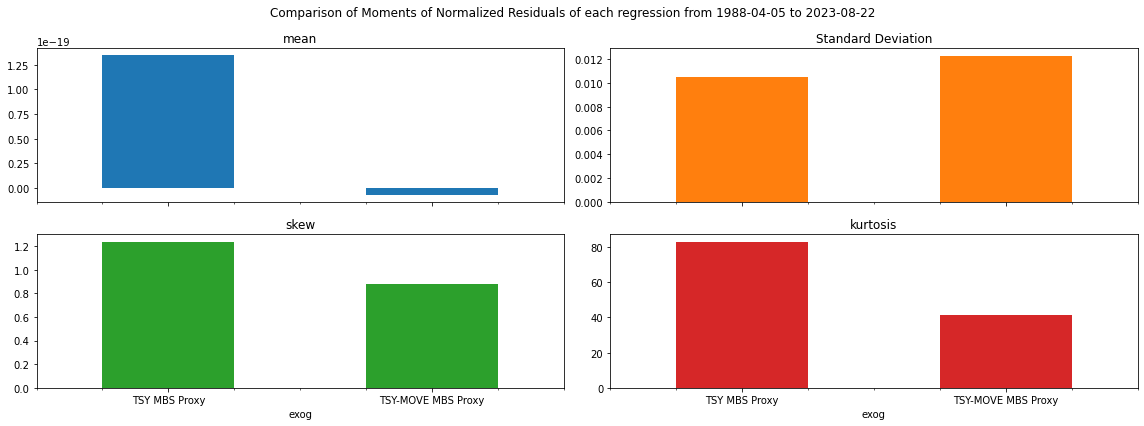

In [12]:
(df_resid_moment.reset_index().drop(
    columns = ["level_1"]).
    set_index("exog").
    plot(
        kind = "bar",
        subplots = True,
        layout = (2,2),
        legend = False,
        rot = 360,
        figsize = (16, 6),
        title = "Comparison of Moments of Normalized Residuals of each regression from {} to {}".format(
            df_tmp.index.min().date(),
            df_tmp.index.max().date())))

plt.tight_layout()
plt.show()